## Diplomatic Event Rating Classifier
Adapted from a Scikit-Learn SVM classifier by Prof. Bengfort, trained on the newspaper articles published 7 days prior to the events.<br>
Pipeline: NLTK Preprocessor, TF-IDF Vectorizer, SGD Classifier<br>
See https://github.com/bbengfort/bbengfort.github.io/blob/master/_posts/2016-05-19-text-classification-nltk-sckit-learn.md
<br>Local file needed: RatingsandText_EventDate.csv

In [1]:
%matplotlib inline

import os
import time
import string
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from operator import itemgetter

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report as clsr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as tts

In [2]:
# Define utilities

def timeit(func):
    """
    Simple timing decorator
    """
    def wrapper(*args, **kwargs):
        start  = time.time()
        result = func(*args, **kwargs)
        delta  = time.time() - start
        return result, delta
    return wrapper


def identity(arg):
    """
    Simple identity function works as a passthrough.
    """
    return arg

### Create the NLTK Preprocessor
A custom stopword list is added to nltk standard 'english' stopwords

In [3]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transforms input data by using NLTK tokenization, lemmatization, and
    other normalization and filtering techniques.
    """

    def __init__(self, stopwords=None, punct=None, lower=True, strip=True):
        """
        Instantiates the preprocessor, which make load corpora, models, or do
        other time-intenstive NLTK data loading.
        """
        stoplist = sw.words('english')
        additionalsw = [u'one', u'first', u'two', u'second', u'three', u'third', u'four',
                        u'fourth', u'five', u'fifth', u'six', u'sixth', u'seven', u'seventh', 
                        u'eight', u'eighth', u'nine', u'ninth', u'ten', u'tenth', u'rsquo', 
                        u'rdquo', u'lsquo', u'ldquo', u'jan', u'january', u'feb', u'february',
                        u'mar', u'march', u'apr', u'april', u'may', u'jun', u'june', u'jul', u'july', 
                        u'aug', u'august', u'sept', u'september', u'oct', u'october', u'nov', 
                        u'november', u'dec', u'december']
        stoplist += additionalsw

        self.lower      = lower
        self.strip      = strip
        self.stopwords  = set(stopwords) if stopwords else set(stoplist)
        self.punct      = set(punct) if punct else set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        """
        Fit simply returns self, no other information is needed.
        """
        return self

    def inverse_transform(self, X):
        """
        No inverse transformation
        """
        return X

    def transform(self, X):
        """
        Actually runs the preprocessing on each document.
        """
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        """
        Returns a normalized, lemmatized list of tokens from a document by
        applying segmentation (breaking into sentences), then word/punctuation
        tokenization, and finally part of speech tagging. It uses the part of
        speech tags to look up the lemma in WordNet, and returns the lowercase
        version of all the words, removing stopwords and punctuation.
        """
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If punctuation or stopword, ignore token and continue
                if token in self.stopwords or all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        """
        Converts the Penn Treebank tag to a WordNet POS tag, then uses that
        tag to perform much more accurate WordNet lemmatization.
        """
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

### Add classification report plotter

In [4]:
def plot_classification_report(cr, title='Classification report', cmap=plt.cm.Reds):

    lines = cr.split('\n')
    classes = []
    plotMat = []

    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    fig, ax = plt.subplots(1)
    fig = plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    for c in range(len(plotMat)+1):
        for r in range(len(classes)):
            try:
                txt = plotMat[r][c]
                ax.text(c,r,plotMat[r][c],va='center',ha='center')
            except IndexError:
                pass
            
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

### Build and Evaluate function: Define pipeline execution, classification report and model storage

In [5]:
@timeit
def build_and_evaluate(X, y, classifier=SGDClassifier, outpath=None, verbose=True):
    """
    Builds a classifer for the given list of documents and targets in two
    stages: the first does a train/test split and prints a classifier report,
    the second rebuilds the model on the entire corpus and returns it for
    operationalization.

    X: a list or iterable of raw strings, each representing a document.
    y: a list or iterable of labels, which will be label encoded.

    Can specify the classifier to build with: if a class is specified then
    this will build the model with the Scikit-Learn defaults, if an instance
    is given, then it will be used directly in the build pipeline.

    If outpath is given, this function will write the model as a pickle.
    If verbose, this function will print out information to the command line.
    """

    @timeit
    def build(classifier, X, y=None):
        """
        Inner build function that builds a single model.
        """
        if isinstance(classifier, type):
            classifier = classifier()

        model = Pipeline([
            ('preprocessor', NLTKPreprocessor()),
            ('vectorizer', TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)),
            ('classifier', classifier),
        ])

        model.fit(X, y)
        return model

    # Label encode the targets
    labels = LabelEncoder()
    y = labels.fit_transform(y)

    # Begin evaluation
    if verbose: print("Building for evaluation")

    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    model, secs = build(classifier, X_train, y_train)

    if verbose: print("Evaluation model fit in {:0.3f} seconds".format(secs))
    if verbose: print("Classification Report:\n")

    y_pred = model.predict(X_test)
    print(clsr(y_test, y_pred, target_names=labels.classes_))
    
    plot_classification_report(clsr(y_test, y_pred, target_names=labels.classes_))

    if verbose: print("Building complete model and saving ...")
    model, secs = build(classifier, X, y)
    model.labels_ = labels

    if verbose: print("Complete model fit in {:0.3f} seconds".format(secs))

    if outpath:
        with open(outpath, 'wb') as f:
            pickle.dump(model, f)
        f.close()
        print("Model written out to {}".format(outpath))

    return model

### Show most information features for an existing model or submitted text

In [16]:
def show_most_informative_features(model, text=None, n=20):
    """
    Accepts a Pipeline with a classifer and a TfidfVectorizer and computes
    the n most informative features of the model. If text is given, then will
    compute the most informative features for classifying that text.

    Note that this function will only work on linear models with coefs_
    """

    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = model.named_steps['vectorizer']
    classifier = model.named_steps['classifier']

    # Check to make sure that we can perform this computation
    if not hasattr(classifier, 'coef_'):
        raise TypeError(
            "Cannot compute most informative features on {} model.".format(
                classifier.__class__.__name__
            )
        )

    if text is not None:
        # Compute the coefficients for the text
        tvec = model.transform([text]).toarray()
    else:
        # Otherwise simply use the coefficients
        tvec = classifier.coef_

    # Zip the feature names with the coefs and sort
    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        key=itemgetter(0), reverse=True
    )

    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    # Create the output string to return
    output = []

    # If text, add the predicted value to the output.
    if text is not None:
        output.append("\"{}\"".format(text.encode('utf-8')))
        category = model.predict([text])
        output.append("Classified as: {}".format(category[0]))
        output.append("")

    # Return the total number of features
    output.append("Total features: {:d}".format(len(coefs)))
    output.append("")
    
    # Create two columns with most negative and most positive features.
    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >15}    {:0.4f}{: >15}".format(cp, fnp.encode('utf-8'), cn, fnn.encode('utf-8'))
        )

    return "\n".join(output)

## Step 1: Retrieve article text and ratings for model building

In [9]:
# Get the article text and ratings

datatable = pd.read_csv('RatingsandText_EventDate.csv', encoding='utf-8')
datatable.sort_values(by='EventDate')

labeldict = { 0: '0-friendly', 1: '1-neutral', 2: '2-threatening', 3: '3-aggressive'}

data = []
target = []

for index, row in datatable.iterrows():
    data.append(row['Title'] + ' ' + row['Text'])
    target.append(labeldict[row['FinalRating']])

## Step 2: Build model, report, and store 

Building for evaluation
Evaluation model fit in 284.587 seconds
Classification Report:

               precision    recall  f1-score   support

   0-friendly       0.80      0.33      0.47        24
    1-neutral       0.67      0.59      0.63       266
2-threatening       0.65      0.60      0.62       358
 3-aggressive       0.62      0.71      0.66       437

  avg / total       0.64      0.64      0.64      1085

Building complete model and saving ...
Complete model fit in 325.663 seconds
Model written out to startovermodel.pickle


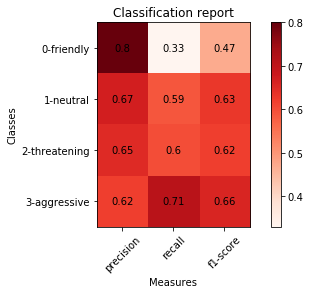

In [13]:
PATH = "model.pickle"

if not os.path.exists(PATH):
    # Build the model
    X = data
    y = target

    model = build_and_evaluate(X,y, outpath=PATH)

## Step 3: Show most informative features of the model
Shows total number of features

In [20]:
with open(PATH, 'rb') as f:
    model = pickle.load(f)

f.close()

print(show_most_informative_features(model))

Total features: 48497

1.8621     convention    -0.8404            use
1.7645          kaine    -0.7828          visit
1.2098       erdoðan    -0.7372           take
1.2019              b    -0.6947           hold
1.1466         baykal    -0.6808        beijing
1.1453            ypg    -0.6636         debate
1.1383        hanegbi    -0.6529       politics
1.1301          asean    -0.6439         crisis
1.1227    arbitration    -0.6109        iranian
1.1223        belgian    -0.6010          syria
1.0736             16    -0.5742       campaign
1.0338          gitmo    -0.5445       pakistan
1.0228      ceasefire    -0.5283          party
1.0220       genocide    -0.5245             14
1.0168        slotkin    -0.5227         weapon
0.9969         kruger    -0.5189         remark
0.9757           glen    -0.5165           cost
0.9634          palin    -0.5154        russian
0.9522      cleveland    -0.5115         office
0.9154          berri    -0.5016        nuclear
